In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, r'C:\Users\lukas\Dokumente\projects\esinet')
import pickle as pkl
import numpy as np
from copy import deepcopy
import mne
import seaborn as sns
import matplotlib.pyplot as plt
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info

plot_params = dict(surface='white', hemi='both', verbose=0)

# shape = (100,2,100)
# img = util.create_n_dim_noise(shape,10)[:,0,:]
# plt.figure()
# plt.imshow(img, cmap='gray', vmin=np.percentile(img, 25), vmax=np.percentile(img, 75))

# Get Forward Model

In [5]:
info = get_info()
info['sfreq'] = 100
fwd = create_forward_model(info=info)
pos = util.unpack_fwd(fwd)[2]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


# Make a simulation

Simulate Source
doing the noise-based source simulation thing


  0%|          | 0/1 [00:00<?, ?it/s]

Converting Source Data to mne.SourceEstimate object


  0%|          | 0/1 [00:00<?, ?it/s]


Project sources to EEG...

Create EEG trials with noise...


  0%|          | 0/1 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
0    10
Name: target_snr, dtype: int64


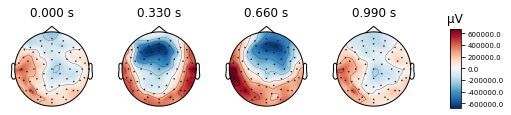

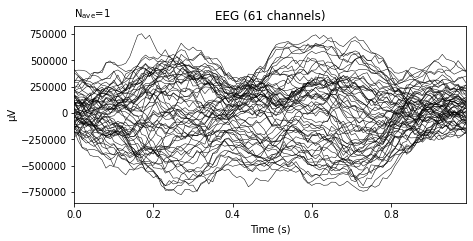

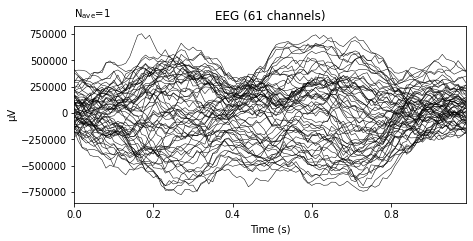

In [66]:
n_samples = 1
duration_of_trial = 1
settings = dict(duration_of_trial=duration_of_trial, method='noise', target_snr=10)
sim_lstm = Simulation(fwd, info, verbose=True, settings=settings).simulate(n_samples=n_samples)
# sim_lstm.source_data[0].plot(**plot_params)
print(sim_lstm.simulation_info["target_snr"])
sim_lstm.eeg_data.average().plot_topomap()
sim_lstm.eeg_data.average().plot()



In [39]:
import time
# Definitions
n = 10
timesteps = 5
shape = (n,n,n,timesteps)
k_neighbors = 5
exponent = 5
# Pre-calculation:
x = np.linspace(pos[:, 0].min(), pos[:, 0].max(), num=shape[0])
y = np.linspace(pos[:, 1].min(), pos[:, 1].max(), num=shape[1])
z = np.linspace(pos[:, 2].min(), pos[:, 2].max(), num=shape[2])

grid = np.stack(np.meshgrid(x,y,z, indexing='ij'), axis=0)
grid_flat = grid.reshape(grid.shape[0], np.product(grid.shape[1:])).T

neighbor_indices = np.stack([np.argsort(np.sqrt(np.sum((grid_flat - coords)**2, axis=1)))[:k_neighbors]
    for coords in pos], axis=0)

# Do for each source

src_3d = util.create_n_dim_noise(shape, exponent=exponent)
src = np.zeros((1284, timesteps))
for i in range(timesteps):
    src[:, i] = util.vol_to_src(neighbor_indices, src_3d[:, :, :, i], pos)

sim_lstm.source_data.data = src
sim_lstm.source_data.plot(**plot_params)
# plt.figure()
# plt.hist(src)

In [37]:
0.018*10000

180.0

In [31]:
vol_to_src(neighbor_indices, src_3d[:, :, :, :], pos).shape

(1284,)

In [32]:
def vol_to_src(neighbor_indices, src_3d, pos):
    '''Interpolate a 3D source to a irregular grid using k-nearest 
    neighbor interpolation.
    '''
    src_3d_flat = src_3d.flatten()
    src = np.zeros(pos.shape[0])
    src = src_3d_flat[neighbor_indices].mean(axis=-1)
    # for i, coords in enumerate(pos):
    #     src[i] = np.mean(src_3d_flat[neighbor_indices[i]])
    return src 

In [ ]:
dur_s = 100
sr = 1000
n = int(dur_s*sr)

t = np.linspace(0,1, num=n)
signal = np.random.randn(n) #+ np.sin(2*np.pi*10*t)*10
signal_fft = np.fft.rfft(signal) / n
freq = np.sqrt(np.arange(n/2+1) + 1)

plt.figure()
plt.subplot(411)
plt.plot(t, signal)

plt.subplot(412)
plt.plot(freq, np.real(signal_fft))
plt.xlabel("Frequency [Hz]")

plt.subplot(413)
pinked = signal_fft / freq**2
plt.plot(freq, np.real(pinked))
plt.xlabel("Frequency [Hz]")



plt.subplot(414)
# pink = np.fft.ifftshift(np.fft.irfft(pinked)).real
pink = np.fft.irfft(pinked).real

plt.plot(pink)

pink_fft = np.fft.rfft(pink)
pink_fft_freq = np.sqrt(np.arange(n/2+1)+1)
plt.figure()
plt.loglog(pink_fft_freq, pink_fft)



In [ ]:
%matplotlib qt
import numpy as np

# n = 1000

# signal = np.random.uniform(-1, 1, (n, n))
# # signal = np.random.randn(n, n)

# signal_fft = np.fft.fft2(signal, ) / n
# freq = np.sqrt(np.arange(n) + 1)


# plt.figure()
# plt.imshow(signal, cmap='gray', vmin=signal.min(), vmax=signal.max())

# plt.figure()
# plt.imshow(np.real(signal_fft), cmap='gray', vmin=np.real(signal_fft).min(), vmax=np.real(signal_fft).max())
# plt.xlabel("Frequency [Hz]")

# plt.figure()
# pinked = signal_fft / (freq**1)[:, np.newaxis]
# pinked /= (freq**1)[np.newaxis, :]
# pinked = signal_fft / np.sqrt( ((freq**2)[np.newaxis, :]+(freq**2)[:, np.newaxis]) )
# plt.imshow(np.real(pinked), cmap='gray', vmin=np.percentile(np.real(pinked), 10), vmax=np.percentile(np.real(pinked), 90))
# plt.xlabel("Frequency [Hz]")


# plt.figure()
# pink = np.fft.ifft2(pinked).real
# plt.imshow(pink, cmap='gray', vmin=np.percentile(np.real(pink), 10), vmax=np.percentile(np.real(pink), 90))


# plt.figure()
# plt.plot(pink[:, 0], label='column')
# plt.plot(pink[0, :], label='row')
# plt.legend()

# pink_fft = np.fft.rfft(pink)
# pink_fft_freq = np.sqrt(np.arange(n/2+1)+1)
# plt.figure()
# plt.loglog(pink_fft_freq, pink_fft)

def create_n_dim_noise(shape, exponent=4):
    signal = np.random.uniform(-1, 1, shape)
    signal_fft = np.fft.fftn(signal, ) / shape[0]
    freq = np.sqrt(np.arange(shape[0]) + 1)
    if len(shape) == 1:
        pinked_fft = signal_fft / np.sqrt( (freq**exponent)[np.newaxis, :] )
    elif len(shape) == 2:
        pinked_fft = signal_fft / np.sqrt( ((freq**exponent)[np.newaxis, :]+(freq**exponent)[:, np.newaxis]) )
    elif len(shape) == 3:
        pinked_fft = signal_fft / np.sqrt( ((freq**exponent)[np.newaxis, np.newaxis, :]+(freq**exponent)[:, np.newaxis, np.newaxis]+(freq**exponent)[np.newaxis, :, np.newaxis]))

    pink = np.fft.ifftn(pinked_fft).real
    return np.squeeze(pink)

n = 100
img = create_n_dim_noise((n,n))
plt.figure()
plt.imshow(img, cmap='gray', vmin=np.percentile(img, 25), vmax=np.percentile(img, 75))

signal = create_n_dim_noise((n,))
plt.figure()
plt.plot(signal)

tensor = create_n_dim_noise((n,n,n))
plt.figure()
plt.imshow(tensor[0], cmap='gray', vmin=np.percentile(tensor[0], 25), vmax=np.percentile(tensor[0], 75))
